<a href="https://colab.research.google.com/github/Tooba-Af/-Customer-Segmentation-Using-RFM-Analysis-/blob/main/Customer_Segmentation_Using_RFM_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd

# Load Excel (UCI dataset is Excel format)
df = pd.read_excel("/content/Online Retail.xlsx")

# Quick check
print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

In [17]:
# Step 2: Data cleaning
df = df[df['CustomerID'].notnull()]      # Remove rows with no CustomerID
df = df[df['Quantity'] > 0]              # Remove cancelled/negative orders
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [18]:
# Step 3: Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [19]:
# Step 4: Snapshot date (1 day after last transaction)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [20]:
# Step 5: Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                   # Frequency
    'TotalPrice': 'sum'                                     # Monetary
})

In [21]:
# Rename columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)


In [22]:
# Step 6: Create RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])


In [23]:
# Combine scores
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)


In [24]:
# Step 7: Define customer segments
def segment_customer(row):
    if row['RFM_Score'] >= 12:
        return 'Champions'
    elif row['RFM_Score'] >= 9:
        return 'Loyal'
    elif row['RFM_Score'] >= 6:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)


In [25]:
# Step 8: Output
print(rfm.head())
print(rfm['Segment'].value_counts())


            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Segment  \
CustomerID                                                                     
12346.0         326          1  77183.60       1       1       5         115   
12347.0           2        182   4310.00       5       5       5         555   
12348.0          75         31   1797.24       2       3       4         234   
12349.0          19         73   1757.55       4       4       4         444   
12350.0         310         17    334.40       1       2       2         122   

            RFM_Score    Segment  
CustomerID                        
12346.0             7  Potential  
12347.0            15  Champions  
12348.0             9      Loyal  
12349.0            12  Champions  
12350.0             5    At Risk  
Segment
Champions    1267
Potential    1134
Loyal        1037
At Risk       901
Name: count, dtype: int64


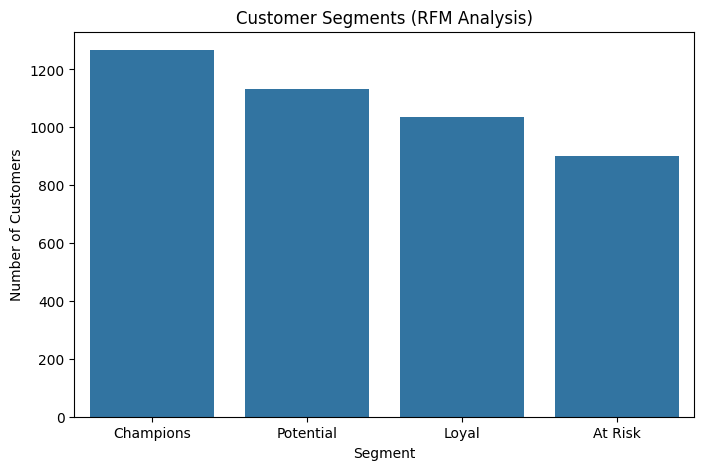

In [26]:
# Step 9: Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title("Customer Segments (RFM Analysis)")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()